<a href="https://colab.research.google.com/github/vishnuaswanth/ML_projects/blob/main/My_M5_MP1_NB_Time_Series_Pollution_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Learning
## A program by IIT Madras and TalentSprint
### Mini Project Notebook : Time series forecasting of pollution

## Learning Objectives


This experiment predicts pollution w.r.t weather conditions.
At the end of the experiment, you will be able to:

* Perform time series analysis of hourly pollution data
* Implement RNN for time series forecasting using Keras




## Dataset

In [ ]:
#@title Download dataset
!gdown "1FDj3TfM6NKaiBzEA8dhxuDDno938i16Z"

Downloading...
From: https://drive.google.com/uc?id=1FDj3TfM6NKaiBzEA8dhxuDDno938i16Z
To: /content/PRSA_data_2010.1.1-2014.12.31.csv
100% 2.01M/2.01M [00:00<00:00, 45.2MB/s]




### Description

In this experiment we use weather and the level of pollution of US embassy in Beijing, China. This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain.

The complete feature list in the raw data is as follows:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.



## Domain Information

 Weather is the state of atmosphere at a particular time and place. It comprises of various components such as wind, temperature, pressure etc. We know from experience that the weather conditions, are similar to the conditions obtaining upto that point of time. In other words, the weather conditions of a day can be predicted by studying the weather conditions of previous days. Hence, it is a perfect example of a time series.

Usually the normal dataset only has observations. But, in time series dataset, there must be one time component.This makes it more complicated and challenging to solve.

**Note:** People often confuse between understanding a time series dataset and predicting the future through dataset. Understanding a time series dataset requires detailed analysis so that you can answer why a particular approach/algorithm is the best fit. While predicting the future, involves considering approaches/algorithms that were used in the historical dataset so that you can use the same and predict the next hour weather.

The power of a time series forecasting model is determined by its performance or accuracy at predicting the future. This is often at the expense of being able to explain why a specific prediction was made, what the confidence intervals are and what are the underlying causes.

## Recurrent Neural Network (RNN)

**Recurrent Neural Networks:**
Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.

**What is a Recurrent Neural Network (RNN)?**

Recurrent neural networks (RNN) are a class of neural networks that are helpful in modeling sequence data. Derived from feedforward networks, RNNs exhibit similar behavior to how human brains function. Simply put: recurrent neural networks produce predictive results in sequential data that other algorithms can’t.


Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and Google's voice search. It is the first algorithm that remembers its input, due to an internal memory, which makes it perfectly suited for machine learning problems that involve sequential data. It is one of the algorithms behind the scenes of the amazing achievements seen in deep learning over the past few years. In this post, we'll cover the basic concepts of how recurrent neural networks work, what the biggest issues are and how to solve them.

**When do you need to use a RNN?**

“Whenever there is a sequence of data and that temporal dynamics that connects the data is more important than the spatial content of each individual frame.”

### Importing Required Packages

In [ ]:

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pandas import read_csv, DataFrame, concat
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

### **Data Preprocessing ( 1 point)**





- The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

- A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset. we can mark them with 0 values for now.

- The code below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.


In [ ]:
# Load and preprocess the dataset
raw_data = read_csv('/content/PRSA_data_2010.1.1-2014.12.31.csv', header=0, index_col=0) # Load the dataset
raw_data = raw_data[24:]
raw_data['pm2.5'].fillna(0, inplace=True)
raw_data['date-time'] = pd.to_datetime(raw_data[['year', 'month', 'day', 'hour']])
pollution_data=raw_data.drop(['year','month','day','hour'], axis=1)
pollution_data.loc[pollution_data['cbwd'] == 'cv', 'cbwd'] = 'SW'

# YOUR CODE HERE

In [ ]:
pollution_data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date-time
No,,,,,,,,,
25,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
26,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
27,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
28,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
29,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


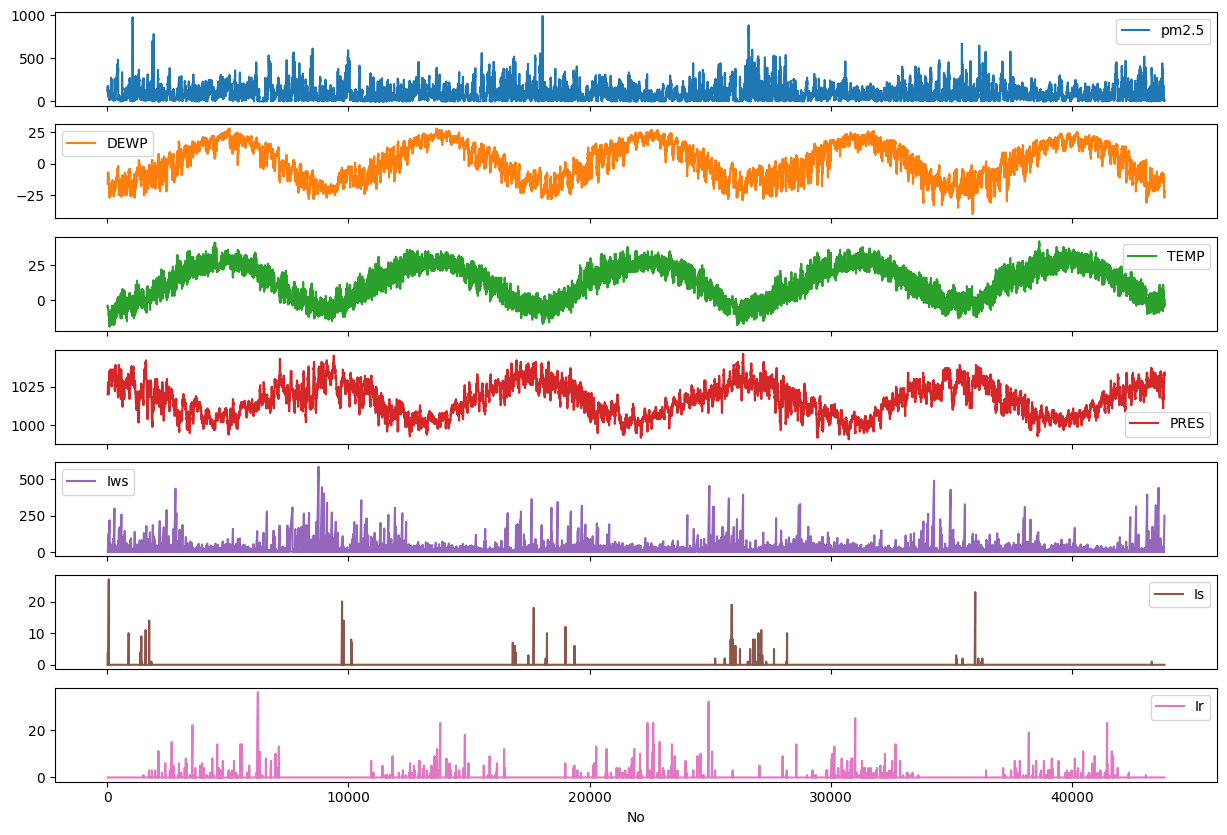

In [ ]:
# Select the columns to plot
cols_to_plot = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

# Create a time series plot
pollution_data[cols_to_plot].plot(subplots=True, figsize=(15, 10))
plt.show()

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'cbwd' column
pollution_data['cbwd_encoded'] = label_encoder.fit_transform(pollution_data['cbwd'])

# Now you have a new column 'cbwd_encoded' with label encoded values
pollution_data = pollution_data.drop(['cbwd'], axis=1)
pollution_data = pollution_data.set_index('date-time')

In [ ]:
# #Initialize OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False)

# # Apply one-hot encoding to the categorical columns
# one_hot_encoded = encoder.fit_transform(pollution_data['cbwd'].values.reshape(-1, 1))

# # Create a DataFrame with the one-hot encoded columns
# # We use get_feature_names_out() to get the column names for the encoded data
# one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['cbwd']))

# # Concatenate the one-hot encoded dataframe with the original dataframe
# pollution_data = pd.concat([pollution_data, one_hot_df], axis=1)

# # Drop the original categorical columns
# df_encoded = pollution_data.drop(['cbwd'], axis=1)
# pollution_data = pollution_data.set_index('date-time')


###  **Data Visualization ( 2 points)**
Create a quick plot of each series

In [ ]:
# Load dataset

# YOUR CODE HERE

# Specify columns to plot

# YOUR CODE HERE

### **Preparing Data for Time Series Prediction ( 2 points )**

- The first step is to prepare the pollution dataset for the Time Series problem.

- This involves framing the dataset as a supervised learning problem and normalizing the input variables.

- We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step. So, the input is features at time step(t-1) and output is pollution at time t.

- We can transform the dataset using the series_to_supervised() function given in code
- Series to supervised function:

    - Intuition is in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.
    - We can see how positive and negative shifts can be used to create a new DataFrame from a time series with sequences of input and output patterns for a supervised learning problem.
    - This permits not only classical X -> y prediction, but also X -> Y where both input and output can be sequences.
    - The function takes four arguments:

        1. data: Sequence of observations as a list or 2D NumPy array. Required.
        2. n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
        3. n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
        4. dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.
        5. The function returns Pandas DataFrame of series framed for supervised learning.




        
- Steps to convert the  Time Series to a Supervised Learning Problem are:
    
    1. Load the “pollution.csv” dataset
    2. Label encoded (integer encoded) the wind speed feature
    3. Normalize the Dataset
    4. Transform the dataset into supervised learning problem by calling the function "series_to_supervised"
    


#### Convert the series to supervised learning problem

In [ ]:
# Convert the time series to supervised problem
# YOUR CODE HERE
# cols_to_normalize = pollution_data.columns.values

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the selected columns
# poluttion_data_normalised = pollution_data.copy()
# poluttion_data_normalised[cols_to_normalize] = scaler.fit_transform(pollution_data[cols_to_normalize])
# poluttion_data_normalised.head()

In [ ]:
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     """
#     Frame a time series as a supervised learning dataset.

#     Arguments:
#     data: Sequence of observations as a 2D NumPy array or DataFrame.
#     n_in: Number of lag observations as input (X). Default is 1.
#     n_out: Number of observations as output (y). Default is 1.
#     dropnan: Boolean whether or not to drop rows with NaN values. Default is True.

#     Returns:
#     Pandas DataFrame of series framed for supervised learning.
#     """
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols, names = list(), list()

#     # Input sequence (t-n, ..., t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

#     # Output sequence (t, t+1, ..., t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

#     # Concatenate all columns
#     agg = pd.concat(cols, axis=1)
#     agg.columns = names

#     # Drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)

#     return agg

In [ ]:
import pandas as pd
import numpy as np

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.

    Arguments:
    data: Sequence of observations as a DataFrame.
    n_in: Number of lag observations as input (X). Default is 1.
    n_out: Number of observations as output (y). Default is 1.
    dropnan: Boolean whether or not to drop rows with NaN values. Default is True.

    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1]
    df = data.copy()
    cols, names = list(), list()

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{col}(t-{i})') for col in df.columns]

    # Output sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{col}(t)') for col in df.columns]
        else:
            names += [(f'{col}(t+{i})') for col in df.columns]

    # Concatenate all columns
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [ ]:
df = pollution_data.copy()
# Define features and target
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_encoded']  # Select all features except 'pm2.5'
target = 'pm2.5'

# 2. Scale the Data

scaler = MinMaxScaler(feature_range=(0, 1))
df[features + [target]] = scaler.fit_transform(df[features + [target]])

In [ ]:
# Prepare the data for supervised learning
supervised_data = series_to_supervised(df, n_in=3, n_out=1)

# 1. Maintain the date-time index (reindex supervised data with the original index)
supervised_data.index = df.index[3:]  # Adjusting for the shift caused by lagging



### Split the Dataset into training and testing data


 Split data into prev 4 years data for training and 1 year of data for testing

In [ ]:
# Split the data into train and test


# Calculate the cutoff date for the split
cutoff_date = supervised_data.index.max() - pd.DateOffset(years=1)

# Split the data into training and testing sets
train_data = supervised_data[supervised_data.index <= cutoff_date]
test_data = supervised_data[supervised_data.index > cutoff_date]

In [ ]:
target_column = f'{target}(t)'
X_train = train_data.drop([target_column], axis=1)
y_train = train_data[target_column]

X_test = test_data.drop([target_column], axis=1)
y_test = test_data[target_column]

In [ ]:
X_train.columns

Index(['pm2.5(t-3)', 'DEWP(t-3)', 'TEMP(t-3)', 'PRES(t-3)', 'Iws(t-3)',
       'Is(t-3)', 'Ir(t-3)', 'cbwd_encoded(t-3)', 'pm2.5(t-2)', 'DEWP(t-2)',
       'TEMP(t-2)', 'PRES(t-2)', 'Iws(t-2)', 'Is(t-2)', 'Ir(t-2)',
       'cbwd_encoded(t-2)', 'pm2.5(t-1)', 'DEWP(t-1)', 'TEMP(t-1)',
       'PRES(t-1)', 'Iws(t-1)', 'Is(t-1)', 'Ir(t-1)', 'cbwd_encoded(t-1)',
       'DEWP(t)', 'TEMP(t)', 'PRES(t)', 'Iws(t)', 'Is(t)', 'Ir(t)',
       'cbwd_encoded(t)'],
      dtype='object')

## Time Series Prediction Techniques

In [ ]:
import numpy as np

# Number of timesteps (lags) used
n_in = 3

# List of columns corresponding to the current time t (future step)
future_columns = ['DEWP(t)', 'TEMP(t)', 'PRES(t)', 'Iws(t)', 'Is(t)', 'Ir(t)', 'cbwd_encoded(t)']

# List of columns for the past timesteps (t-3, t-2, t-1)
past_columns = [
    ['pm2.5(t-3)', 'DEWP(t-3)', 'TEMP(t-3)', 'PRES(t-3)', 'Iws(t-3)', 'Is(t-3)', 'Ir(t-3)', 'cbwd_encoded(t-3)'],
    ['pm2.5(t-2)', 'DEWP(t-2)', 'TEMP(t-2)', 'PRES(t-2)', 'Iws(t-2)', 'Is(t-2)', 'Ir(t-2)', 'cbwd_encoded(t-2)'],
    ['pm2.5(t-1)', 'DEWP(t-1)', 'TEMP(t-1)', 'PRES(t-1)', 'Iws(t-1)', 'Is(t-1)', 'Ir(t-1)', 'cbwd_encoded(t-1)']
]

# Separate the features (X) from the target (pm2.5 at current timestep t)
X_columns = [col for sublist in past_columns for col in sublist]

# Extract the input features (X) for training and testing
X_train = train_data[X_columns]
X_test = test_data[X_columns]

# Extract the target (y) which is the pm2.5 at the current timestep t
y_train = train_data['pm2.5(t)']
y_test = test_data['pm2.5(t)']

# Reshape input for LSTM - [samples, timesteps, features]
def reshape_for_lstm(X, n_in):
    # Convert to NumPy array
    X_values = X.values
    # Reshape the input data to 3D (samples, timesteps, features)
    return X_values.reshape((X_values.shape[0], n_in, int(X_values.shape[1] / n_in)))

# Reshape the training and test data for LSTM
X_train_lstm = reshape_for_lstm(X_train, n_in)
X_test_lstm = reshape_for_lstm(X_test, n_in)

# Check the shape of the reshaped data
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)


X_train_lstm shape:  (35037, 3, 8)
X_test_lstm shape:  (8760, 3, 8)


### **Build and compile an RNN/LSTM model ( 3 points )**

In [ ]:
# Step 1 - Build the architecture
# YOUR CODE HERE
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))  # Output layer for predicting a single value (pm2.5)





/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 2 - Compile the model
# YOUR CODE HERE
model.compile(optimizer='adam', loss='mse')





### **Training the RNN on Pollution dataset ( 1 points )**


This is a regression problem. Hence we focus on the loss reduction, instead of accuracy measures to evaluate the model.


In [ ]:
# Train the LSTM model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=72, validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)


Epoch 1/50
487/487 - 5s - 11ms/step - loss: 0.0027 - val_loss: 0.0071
Epoch 2/50
487/487 - 2s - 5ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 3/50
487/487 - 2s - 5ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 4/50
487/487 - 2s - 4ms/step - loss: 8.4742e-04 - val_loss: 0.0013
Epoch 5/50
487/487 - 2s - 4ms/step - loss: 8.0266e-04 - val_loss: 0.0012
Epoch 6/50
487/487 - 3s - 6ms/step - loss: 7.8921e-04 - val_loss: 0.0012
Epoch 7/50
487/487 - 2s - 4ms/step - loss: 7.8091e-04 - val_loss: 0.0012
Epoch 8/50
487/487 - 2s - 4ms/step - loss: 7.7408e-04 - val_loss: 0.0012
Epoch 9/50
487/487 - 3s - 5ms/step - loss: 7.6721e-04 - val_loss: 0.0012
Epoch 10/50
487/487 - 2s - 4ms/step - loss: 7.6094e-04 - val_loss: 0.0011
Epoch 11/50
487/487 - 3s - 7ms/step - loss: 7.5588e-04 - val_loss: 0.0011
Epoch 12/50
487/487 - 4s - 9ms/step - loss: 7.5146e-04 - val_loss: 0.0011
Epoch 13/50
487/487 - 3s - 5ms/step - loss: 7.4851e-04 - val_loss: 0.0011
Epoch 14/50
487/487 - 2s - 4ms/step - loss: 7.4465e-04 - v

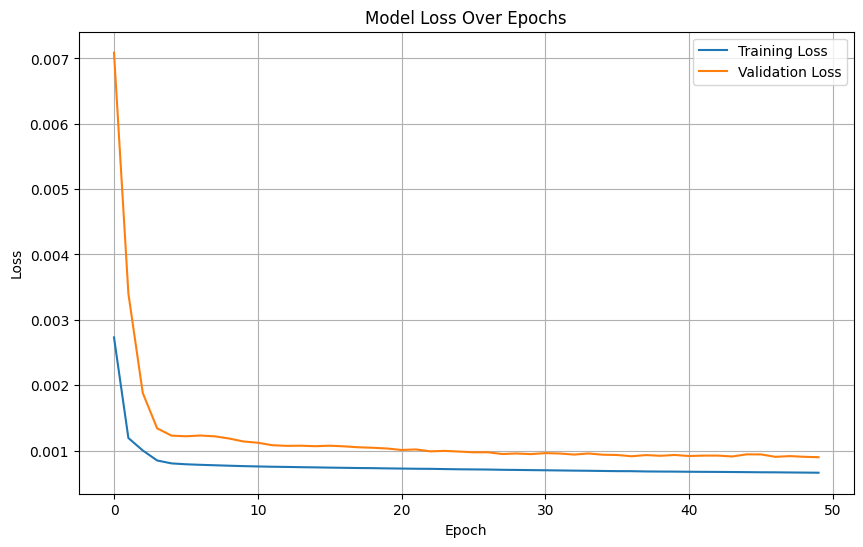

In [ ]:
# Plot the loss
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



### **Testing the model(1 points)**

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 0.0008973834530110693


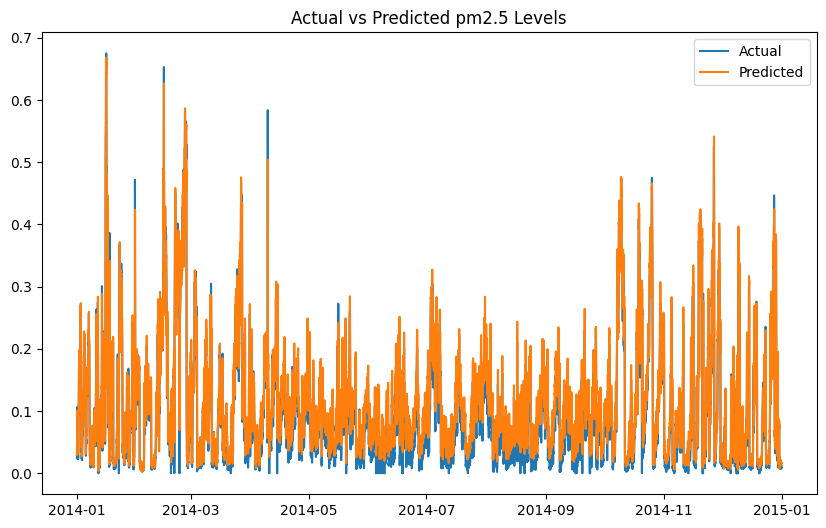

In [ ]:
# Evaluate the model on Test set
# Make predictions
y_pred = model.predict(X_test_lstm)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted pm2.5 Levels')
plt.show()